<a href="https://colab.research.google.com/github/vicentegilso/BitcoinPrediction/blob/main/ModelosBitcoinLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Download library ###

import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import datetime as dt
from pandas_datareader import data
def parser(x):
    return datetime.strptime('20'+x, '%Y-%m-%d-%H-%M')
import numpy as np
from enum import Enum
import datetime as dt
from pandas_datareader import data

dataset_raw = data.DataReader('BTC-USD','yahoo', dt.datetime(2017,1,1), dt.datetime.now())
dataset_raw.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008.0,998.325012
2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992.0,1021.750000
2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,1043.839966
2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1154.729980
2017-01-05,1191.099976,910.416992,1156.729980,1013.380005,510199008.0,1013.380005


In [112]:
#Luego vamos a definir dos clases, ActionColorMapping y ActionPricePoint#

class ActionColorMapping(Enum):
    SELL = 'red'
    BUY = 'green'

class ActionPricePoint:
    def __init__(self, price, date, action):
        self.price = price
        self.date = date
        self.action = action

In [113]:
#Evaluar si estamos en condiciones de vender y otra que evalúa si estamos en condiciones de comprar#
def sell():     
    return lambda left, right: left < right 

def buy():     
    return lambda left, right: left >= right

In [119]:
#Visualizar el precio, las medias móviles y los puntos de compra y venta que se hayan manifestado en el pasado#
def plot(price, ma_20, ma_100, action_price_points):     
    ax = price.plot()     
    
    ma_20.plot(label='Moving Average 20 Days', ax=ax)     
    ma_100.plot(label='Moving Average 100 Days', ax=ax)     
    
    ax.set_xlabel('Date')     
    ax.set_ylabel('Closing Price')     
    ax.set_title('BTC-USD. Closing Price')     
    ax.legend(loc='upper left')     
    
    for position in action_price_points:         
        plt.scatter(position.date, position.price, s=600, c=position.action.value)     
    
    plt.show()

In [147]:
# implementación del algoritmo de cruces de medias móviles#

def retrieve_closing_price(symbol):     
    df = data.DataReader('BTC-USD','yahoo', dt.datetime(2017,1,1), dt.datetime.now())    
    return df['Close'] 

def data_not_available(price):     
    return np.isnan(price) 

def calculate_moving_average_crossovers(symbol):     
    closing_price = retrieve_closing_price(symbol)     
    
    rm_20 = closing_price.rolling(window=20).mean()     
    rm_100 = closing_price.rolling(window=100).mean()     
    
    action = ActionColorMapping.SELL     
    signal_detected = sell()     
    signals = []     
    
    for index in range(closing_price.size):         
        if data_not_available(rm_20[index]) or data_not_available(rm_100[index]):             
            continue         
        
        if signal_detected(rm_20[index], rm_100[index]):          
            mean_price = (rm_20[index] + rm_100[index]) / 2             
            action = ActionPricePoint(mean_price, index, action)             
            signals.append(action)         
        
        if rm_20[index] >= rm_100[index]:             
            action = ActionColorMapping.SELL             
            signal_detected = sell()         
        else:             
            action = ActionColorMapping.BUY            
            signal_detected = buy()     

if __name__ == '__main__':     
    calculate_moving_average_crossovers('BTC-USD')


In [2]:
# ligeramente modificada para escoger la variable objetivo
def create_dataset(dataset, look_back_memory=1, idx_target=-1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory])
        dataY.append(dataset[i+look_back_memory, idx_target])
    return np.array(dataX), np.array(dataY)

In [3]:
X, Y = create_dataset(dataset_raw.values, look_back_memory=10, idx_target=3)
print(X.shape)
print(Y.shape)

(1561, 10, 6)
(1561,)


In [4]:
# hacemos el import de todo lo que utilizaremos
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



In [5]:
# fijamos la semilla para obtener resultados reproducibles
np.random.seed(42)

In [6]:
dataset_raw.shape

(1572, 6)

In [7]:
dataframe = dataset_raw.drop(columns=['Adj Close', 'High', 'Low',])
dataframe.describe()

,Open,Close,Volume
count,1572.000000,1572.000000,1.572000e+03
mean,10448.921214,10478.677978,1.809683e+10
std,11602.645255,11641.152291,2.067562e+10
min,775.177979,777.757019,6.085170e+07
25%,4347.042480,4362.554932,4.055497e+09
50%,7783.005127,7801.329834,1.210100e+10
75%,10345.483887,10346.048096,2.552766e+10
max,63523.753906,63503.457031,3.509679e+11


In [8]:
# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe)


In [9]:
dataset.min(axis=0)

array([0., 0., 0.])

In [10]:
scaler.data_min_

array([7.75177979e+02, 7.77757019e+02, 6.08517000e+07])

In [11]:
scaler.data_max_

array([6.35237539e+04, 6.35034570e+04, 3.50967941e+11])

In [12]:
# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [13]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=1 y solo tendremos una variable,
# con lo que V=10 (número de pasajeros).
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1042, 10, 3) (1042,)
(508, 10, 3) (508,)


In [15]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 3
trainX = np.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = np.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(1042, 10, 3)
(508, 10, 3)


In [16]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(LSTM(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

Epoch 1/25
1042/1042 [==============================] - 4s 2ms/step - loss: 9.9539e-04
Epoch 2/25
1042/1042 [==============================] - 2s 2ms/step - loss: 8.4665e-05
Epoch 3/25
1042/1042 [==============================] - 2s 2ms/step - loss: 8.4252e-05
Epoch 4/25
1042/1042 [==============================] - 3s 3ms/step - loss: 6.0175e-05
Epoch 5/25
1042/1042 [==============================] - 3s 2ms/step - loss: 5.6099e-05
Epoch 6/25
1042/1042 [==============================] - 3s 2ms/step - loss: 5.6419e-05
Epoch 7/25
1042/1042 [==============================] - 3s 2ms/step - loss: 6.8586e-05
Epoch 8/25
1042/1042 [==============================] - 3s 2ms/step - loss: 7.1202e-05
Epoch 9/25
1042/1042 [==============================] - 2s 2ms/step - loss: 4.5724e-05
Epoch 10/25
1042/1042 [==============================] - 2s 2ms/step - loss: 4.8764e-05
Epoch 11/25
1042/1042 [==============================] - 3s 2ms/step - loss: 4.4353e-05
Epoch 12/25
1042/1042 [==================

In [17]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
# una vez hechas las predicciones, tenemos que des-normalizarlas
xmin = scaler.data_min_[-2]
xmax = scaler.data_max_[-2]
trainPredict = trainPredict * (xmax - xmin) + xmin
trainY_orig = trainY * (xmax - xmin) + xmin
testPredict = testPredict * (xmax - xmin) + xmin
testY_orig = testY * (xmax - xmin) + xmin

Train Score: 376.65 RMSE
Test Score: 3541.38 RMSE


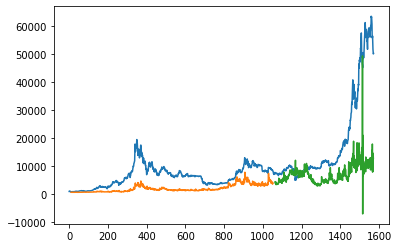

In [19]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = np.full(dataset.shape[0], np.nan)
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory] = trainPredict[:, 0]

# y lo mismo para el test
testPredictPlot = np.full(dataset.shape[0], np.nan)
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1] = testPredict[:, 0]

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(dataset_raw['Close'].values)          
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()